In [1]:
%matplotlib inline
import heartpy as hp
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"  # allows multiple prints from a cell
from IPython.display import display
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, os, plotly.express as px, xgboost as xgb, re
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
import seaborn as sns
from sentence_transformers import SentenceTransformer as SBERT
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm.notebook import tqdm_notebook
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from xgboost import XGBClassifier
from tqdm.notebook import tqdm
import json

# Import 3rd party libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

os.environ['TF_DETERMINISTIC_OPS'] = '1'; os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
np.set_printoptions(linewidth=10000, precision=2, edgeitems=20, suppress=True)
pd.set_option('display.max_colwidth', 1000, 'display.max_columns', 20, 'display.width', 10000, 'display.max_rows', 8)

In [2]:
data_df = pd.read_csv("task_1/train/train_gts.csv")
meta_df = pd.read_csv("task_1/train/train_meta.csv")
test_meta_df = pd.read_csv("task_1/test/test_meta.csv")
selected_scp_codes = []
selected_words = []

# extract features

In [3]:
# подсчет статистик по ЭКГ данным
def open_hr_data(filenames, is_train=True):
    total_data = []
    for filename in tqdm(filenames):
        filename = filename.split("/")[-1]
        with open(f"task_1/{'train' if is_train else 'test'}/{filename}.npy", "rb") as f:
            data = np.load(f, allow_pickle=True)
        stats = []
        total_data.append([])
        for i in range(12):
            # if i in [0, 6]:
                total_data[-1].extend([data[i].min(), data[i].max(), data[i].mean()])
    columns = []
    for i in range(12):
        # if i in [0, 6]:
            columns.extend([f"min_{i}", f"max_{i}", f"mean_{i}"])
    return total_data, columns


def prepare_df(df, is_train=True):
    global selected_scp_codes, selected_words
    
    # encode scp_codes to matrix (num_of_patients, num_of_unique_scp_codes)
    all_keys = df['scp_codes'].map(lambda x: list(json.loads(x.replace("'", '"')).items())).to_list()

    # создание bag of words (для теста нужно сохранить такие колонки, как и в трейне)
    if is_train:
        unique_keys = set()
        for user_data in all_keys:
            for value in user_data:
                unique_keys.add(value[0])
        unique_keys = list(unique_keys)
        selected_scp_codes = unique_keys
    else:
        unique_keys = selected_scp_codes
    scp_codes_matrix = np.empty((len(all_keys), len(unique_keys)))
    scp_codes_matrix[:] = np.nan
    for i, user_data in enumerate(all_keys):
        for value in user_data:
            if value[0] in unique_keys:
                scp_codes_matrix[i, unique_keys.index(value[0])] = value[1]
    df_scp_codes = pd.DataFrame(scp_codes_matrix, columns=unique_keys)  # .add_prefix("scp_")
    df = df.join(df_scp_codes)

    # создание bag of scp codes аналогично 
    if is_train:
        unique_words = dict()
        for text in df["translatted_report"]:
            for word in text.split():
                if word != "":
                    if word in unique_words:
                        unique_words[word] += 1
                    else:
                        unique_words[word] = 1
        usable_words = [x[0] for x in sorted(unique_words.items(), key=lambda x: -x[1])[:300]]
        selected_words = usable_words
    else:
        usable_words = selected_words
    words_matrix = np.empty((len(all_keys), len(usable_words)))
    words_matrix[:] = 0
    for i, text in enumerate(df["translatted_report"]):
        for word in text.split():
            if word != "" and word in usable_words:
                words_matrix[i, usable_words.index(word)] += 1
    df_words = pd.DataFrame(words_matrix, columns=usable_words).add_prefix("word_")
    df = df.join(df_words)

    # change dtype of other columns to str
    df["device"] = df["device"].astype(str)
    df["heart_axis"] = df["heart_axis"].astype(str)
    df["baseline_drift"] = df["baseline_drift"].astype(str)
    df["static_noise"] = df["static_noise"].astype(str)
    df["burst_noise"] = df["burst_noise"].astype(str)
    df["electrodes_problems"] = df["electrodes_problems"].astype(str)
    df["extra_beats"] = df["extra_beats"].astype(str)
    df["pacemaker"] = df["pacemaker"].astype(str)
    df["infarction_stadium1"] = df["infarction_stadium1"].astype(str)
    df["infarction_stadium2"] = df["infarction_stadium2"].astype(str)

    # encode str datetime to count days till today
    df["recording_date"] = df.recording_date.map(lambda x: pd.Timestamp(x))
    df["recording_date_norm"] = (df["recording_date"] - pd.Timestamp(2023)).dt.total_seconds()

    # статистика по экг данным
    hr_opened, columns = open_hr_data(df["filename_hr"].to_list(), is_train=is_train)
    df_hr_opened = pd.DataFrame(hr_opened, columns=columns).add_prefix("hr_") #.groupby("index").agg(["max", "min", "std"])
    df = df.join(df_hr_opened)

    ecg_stats = np.load("dnn_output.npy")
    df_ecg_stats = pd.DataFrame(ecg_stats, columns=["state"]).add_prefix("ecg_")
    df = df.join(df_ecg_stats)

    if is_train:
        df = df.drop(columns=['recording_date', 'report', 'scp_codes', 'filename_lr', 'filename_hr', 'record_name', 'patient_id', 'ecg_id', 'translatted_report'])
    
    return df

In [4]:
df_merged = pd.merge(meta_df, data_df, on="record_name")
# добавляем новые переводы текстов
df_merged["translatted_report"] = pd.read_csv("reports.csv")["translatted_report"]
# добавляем предикты от resnet модели
df_merged = pd.merge(df_merged, pd.read_csv("predicted_train.csv"), on="record_name")

## working with hr data

# TRAIN

In [5]:
df_prepared = prepare_df(df_merged)

  0%|          | 0/1346 [00:00<?, ?it/s]

In [6]:
train_columns = ["myocard"] + ["infarction_stadium1", "ASMI", "word_infarction", "word_normal", "IMI", "word_qrs(t)", "word_old", "ABQRS", "word_anteroseptal",
                               "NORM", "heart_axis", "word_abnormal", "hr_min_5", "hr_max_8", "hr_max_4", "hr_max_1", "word_undetermined", "age", "word_sinus",
                               "hr_max_9", "word_left", "nurse", "word_ii,", "word_complexes", "QWAVE", "hr_min_9", "word_consistent", "word_infarct", "LAFB", # "word_446",
                               "hr_max_5", "word_inferior", "word_report", "hr_min_10", "hr_max_3", "word_waves", "word_segments", "strat_fold", "word_but", "word_qs", "ILMI"]

In [7]:
train_columns = train_columns + ["dl_score"]

## catboost + cross-validation

In [8]:
n_splits = 5

selected_columns = [x for x in train_columns if x != "myocard"] 
train_df = df_prepared.copy()[train_columns]
cat_features = [x for x in ["device", "heart_axis", "baseline_drift", "static_noise",
                "burst_noise", "electrodes_problems", "extra_beats", "pacemaker",
               "infarction_stadium1", "infarction_stadium2"] if x in train_columns]

for col in cat_features:
    train_df[col] = train_df[col].astype('category')

X = train_df.drop(columns=["myocard"])
y = train_df["myocard"]

In [9]:
clfs = []
scores = []
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

for train_index, test_index in kf.split(X, y):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    clf = CatBoostClassifier(
        depth=10,
        iterations=500,
        learning_rate=0.06,
        loss_function="MultiClass", 
        eval_metric="TotalF1:average=Macro", 
        custom_metric="TotalF1:average=Macro",
        boosting_type="Ordered",
        
        # Главная фишка катбуста - работа с категориальными признаками
        cat_features=cat_features,
        # ignored_features = ignored_features,
        
        # Регуляризация и ускорение
        colsample_bylevel=0.098,
        subsample=0.95,
        l2_leaf_reg=9,
        min_data_in_leaf=243,
        max_bin=187,
        random_strength=1,
        
        # Параметры ускорения
        task_type="CPU",    
        thread_count=-1,
        bootstrap_type="Bernoulli", 
        
        # Важное!
        random_seed=7575,
        # auto_class_weights="SqrtBalanced",
        early_stopping_rounds=50)

    clfs.append(clf)

    clf.fit(
        X_train, y_train,
        eval_set=(X_test, y_test),
        verbose=100,
        use_best_model=True,
        plot=False)

    y_pred = clf.predict(X_test)
    score = f1_score(y_test, y_pred, average="macro")  # np.mean(np.array(y_pred == y_test))
    scores.append(score)
    print(f"\nfold: f1 score: {score} \n")

assert len(clfs) == n_splits
print(
    "mean f1 score ====>>> " + str(np.mean(scores, dtype="float32")) + " <<<====", np.std(scores).round(4), "\n"
)

0:	learn: 0.8352257	test: 0.8698691	best: 0.8698691 (0)	total: 142ms	remaining: 1m 10s
100:	learn: 0.9183381	test: 0.9137913	best: 0.9178332 (55)	total: 5.66s	remaining: 22.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9178332319
bestIteration = 55

Shrink model to first 56 iterations.



fold: f1 score: 0.9178332318928788 

0:	learn: 0.8634545	test: 0.7973680	best: 0.7973680 (0)	total: 75.9ms	remaining: 37.9s
100:	learn: 0.9281829	test: 0.8739203	best: 0.8947792 (56)	total: 5.64s	remaining: 22.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8947792274
bestIteration = 56

Shrink model to first 57 iterations.



fold: f1 score: 0.8947792273532593 

0:	learn: 0.8661496	test: 0.7608474	best: 0.7608474 (0)	total: 89.9ms	remaining: 44.8s
100:	learn: 0.9185174	test: 0.9060098	best: 0.9060098 (75)	total: 6.13s	remaining: 24.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9060097834
bestIteration = 75

Shrink model to first 76 iterations.



fold: f1 score: 0.906009783368274 

0:	learn: 0.8338456	test: 0.8245016	best: 0.8245016 (0)	total: 94.4ms	remaining: 47.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9060097834
bestIteration = 36

Shrink model to first 37 iterations.



fold: f1 score: 0.906009783368274 

0:	learn: 0.8589432	test: 0.8426594	best: 0.8426594 (0)	total: 161ms	remaining: 1m 20s
100:	learn: 0.9155544	test: 0.9219507	best: 0.9219507 (99)	total: 5.8s	remaining: 22.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9219506751
bestIteration = 99

Shrink model to first 100 iterations.



fold: f1 score: 0.921950675147863 

mean f1 score ====>>> 0.90931654 <<<==== 0.0096 



## Get catboost features importances

['dl_score', 'infarction_stadium1', 'ASMI', 'word_infarction', 'word_old', 'word_qrs(t)', 'IMI', 'word_inferior', 'ABQRS', 'word_anteroseptal', 'NORM', 'word_normal', 'nurse', 'hr_max_8', 'hr_max_5', 'age', 'word_undetermined', 'hr_max_1', 'hr_max_9', 'hr_min_5', 'word_report', 'word_left', 'hr_min_9', 'hr_max_4', 'hr_max_3', 'hr_min_10', 'QWAVE', 'word_abnormal', 'word_consistent', 'ILMI', 'LAFB', 'heart_axis', 'word_waves', 'word_complexes', 'strat_fold', 'word_segments', 'word_but', 'word_sinus', 'word_qs', 'word_ii,', 'word_infarct']
Всего признаков 41 Усреднее по 5-ти моделям: 
На график нанесено топ-41 признаков


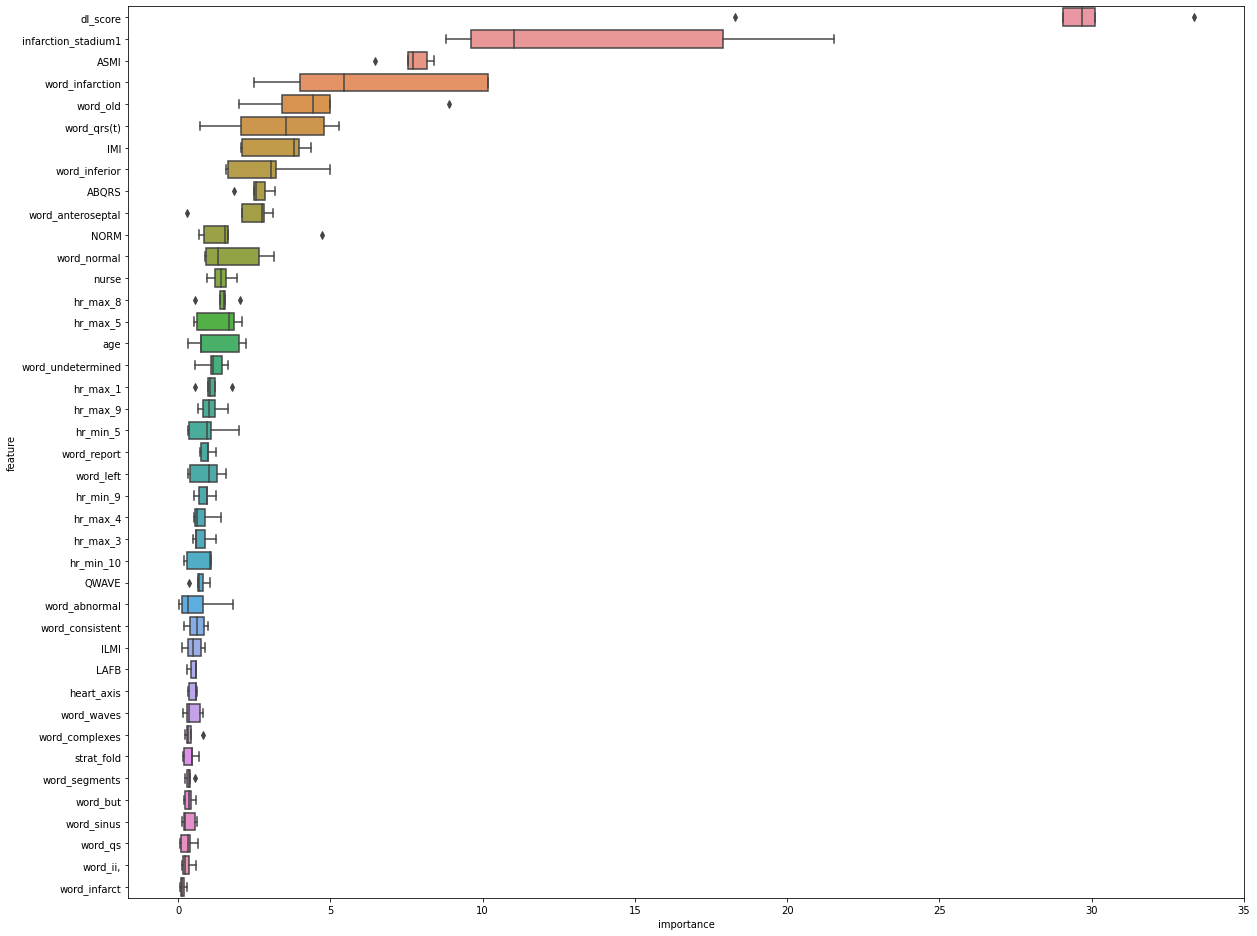

In [10]:
def plot_importance(df, best_model, height, top_n=50):

    top_n = min(top_n, df.shape[1])

    # Извлекаем значения из модели
    fi = pd.DataFrame(index=df.columns, columns=[])
    for i, m in enumerate(best_model):
        fi[f"m_{i}"] = m.feature_importances_

    fi = fi.stack().reset_index().iloc[:, [0, 2]]
    fi.columns = ["feature", "importance"]

    # Определяем порядок признаков и отбираем только n признаков для отрисовки
    cols_ord = (
        fi.groupby("feature")["importance"]
        .mean()
        .sort_values(ascending=False)
        .index.tolist()
    )
    
    print(cols_ord)
    
    cols_ord = cols_ord[:top_n]

    fi = fi[fi["feature"].isin(cols_ord)]  # Выравниваем порядок по убыванию важности
    print( "Всего признаков {} Усреднее по {}-ти моделям: ".format(len(cols_ord), len(best_model)))

    # Отрисовываем боксплоты фичей
    plt.figure(figsize=(20, len(cols_ord) * height))
    b = sns.boxplot(data=fi, y="feature", x="importance", orient="h", order=cols_ord)

    print("На график нанесено топ-{} признаков".format(top_n))
    return (
        fi.groupby(by=["feature"], as_index=False)["importance"]
        .mean()
        .sort_values(by="importance", ascending=False)
    )


df_feats_imp = plot_importance(
    X, #train[filtered_features].drop(targets, axis=1, errors="ignore"),
    clfs,
    0.40,
    top_n=100,
)

## Selecting best params for catboost

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [12]:
import catboost as cb
from sklearn.metrics import mean_squared_error
import optuna

def objective(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),

        "loss_function": "MultiClass",  # MultiLogloss MultiClass
        "eval_metric": "TotalF1:average=Macro",  # 'AUC / Accuracy,
        "custom_metric": "TotalF1:average=Macro",
        "boosting_type": "Ordered",
        
        # Главная фишка катбуста - работа с категориальными признаками
        "cat_features": cat_features,
        # ignored_features = ignored_features,
        
        # Регуляризация и ускорение
        "l2_leaf_reg": 9,
        "max_bin": 187,
        "random_strength": 1,
        
        # Параметры скорения
        "task_type": "CPU",    
        "thread_count": -1,
        "bootstrap_type": "Bernoulli", 
        
        # Важное!
        "random_seed": 7575,
    #    auto_class_weights="SqrtBalanced",
        "early_stopping_rounds": 50
    }

    model = cb.CatBoostClassifier(**params, silent=True)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = f1_score(y_test, predictions, average="macro")
    return rmse

In [13]:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=30)

In [14]:
# study.best_trial.params

## Get SHAP-values

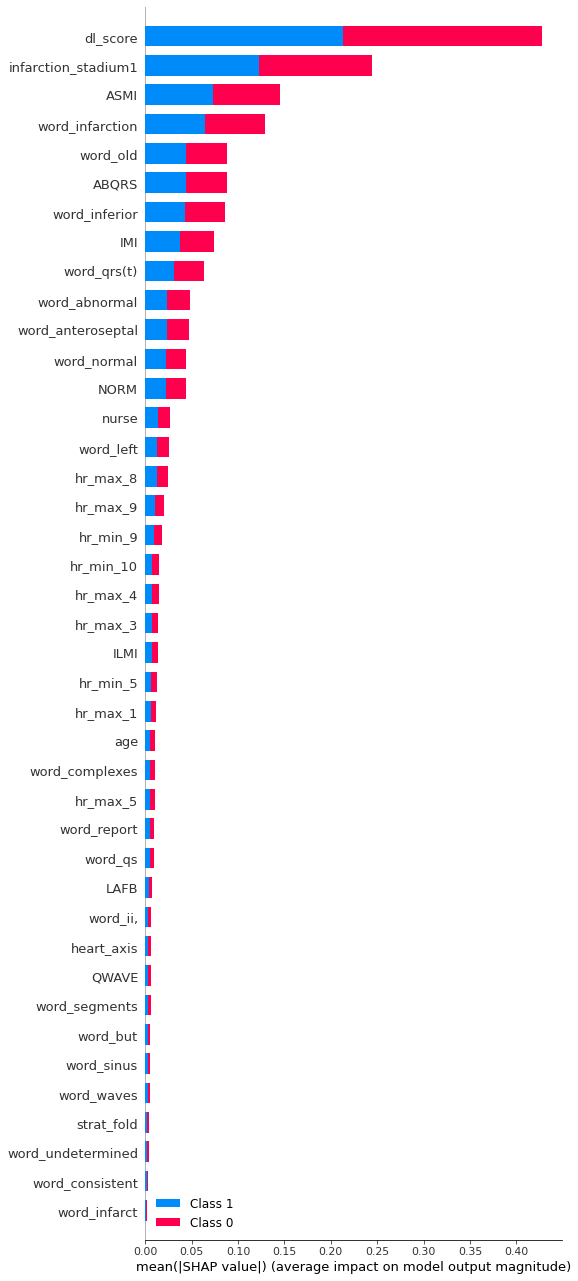

In [15]:
# Посмотрим на SHAP values
import shap

explainer = shap.TreeExplainer(clfs[0])

val_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X_test, max_display=100)

# make predicts

In [16]:
test_meta_df = pd.read_csv("task_1/test/test_meta.csv")
sample_df = pd.read_csv("sample.csv")
test_meta_df["translatted_report"] = pd.read_csv("reports_test.csv")["translatted_report"]
test_meta_df = pd.merge(test_meta_df, pd.read_csv("predicted_test.csv"))
test_meta_df["dl_score"] = test_meta_df["predict"]
test_prepared_df = prepare_df(test_meta_df, is_train=False)

  0%|          | 0/449 [00:00<?, ?it/s]

In [17]:
# массив для записи финального прогноза size*n_class
test_data = test_prepared_df.copy()
X_test = test_data[selected_columns]
y_pred = np.zeros((X_test.shape[0], df_prepared["myocard"].nunique()))

# Используем все модели из списка clfs для инференса
for n, clf in enumerate(clfs):
    y_pred += clf.predict_proba(X_test)

test_df = pd.DataFrame()
test_df["record_name"] = test_meta_df["record_name"]

f = lambda x: clf.classes_[x]
test_df["myocard"] = list(map(f, y_pred.argmax(axis=1)))

total_df = sample_df.merge(test_df, on="record_name", suffixes=("_x", ""))
total_df[["record_name", "myocard"]].to_csv("submit.csv", index=False)
total_df

,record_name,myocard_x,myocard
0,01165_hr,1,0
1,01252_hr,1,0
2,02668_hr,1,0
3,04165_hr,1,0
...,...,...,...
445,15114_hr,0,0
446,15819_hr,0,0
447,19041_hr,1,0
448,19918_hr,1,0


In [18]:
test_with_preds = test_meta_df.merge(total_df[["record_name", "myocard"]], on="record_name")
test_preds_df = prepare_df(test_with_preds, is_train=False)
probs = [100]
test_preds_df.loc[test_preds_df["AMI"].isin(probs) | (test_preds_df["IPMI"].isin(probs)) |
              test_preds_df["LMI"].isin(probs) | (test_preds_df["IPLMI"].isin(probs)) |
              test_preds_df["ILMI"].isin(probs) | (test_preds_df["IMI"].isin(probs)) |
              (test_preds_df["ASMI"].isin(probs)) |
              test_preds_df["ALMI"].isin(probs), "myocard"] = 1

  0%|          | 0/449 [00:00<?, ?it/s]

In [19]:
total_df = sample_df.merge(test_preds_df, on="record_name", suffixes=("_x", ""))
total_df[["record_name", "myocard"]].to_csv("submit.csv", index=False)
total_df

,record_name,myocard_x,ecg_id,patient_id,age,sex,height,weight,nurse,site,...,hr_min_9,hr_max_9,hr_mean_9,hr_min_10,hr_max_10,hr_mean_10,hr_min_11,hr_max_11,hr_mean_11,ecg_state
0,01165_hr,1,1165,1413.0,33.0,0,166.0,70.0,3.0,1.0,...,-0.501,3.214,-0.008304,-0.446,2.276,-0.003498,-0.350,1.839,-0.006675,0.000025
1,01252_hr,1,1252,10312.0,28.0,1,NaN,59.0,0.0,0.0,...,-0.449,1.915,0.000298,-0.396,1.677,-0.002583,-0.435,1.300,-0.002842,0.000224
2,02668_hr,1,2668,3019.0,55.0,0,184.0,97.0,6.0,1.0,...,-1.360,1.300,-0.014928,-1.565,1.570,-0.011762,-2.135,2.855,-0.009292,0.000073
3,04165_hr,1,4165,20642.0,31.0,0,NaN,91.0,0.0,0.0,...,-0.561,1.481,-0.006428,-0.325,1.430,0.000058,-0.299,1.190,-0.001265,0.199707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,15114_hr,0,15114,1618.0,63.0,1,160.0,62.0,3.0,1.0,...,-1.274,0.691,-0.003710,-0.616,0.730,0.002000,-0.366,0.588,-0.001910,0.000065
446,15819_hr,0,15819,8682.0,57.0,1,NaN,90.0,0.0,0.0,...,-0.322,0.806,-0.002522,-0.285,0.942,-0.004120,-0.243,0.967,-0.004188,0.000905
447,19041_hr,1,19041,16613.0,42.0,0,NaN,NaN,0.0,0.0,...,-0.224,0.947,-0.000828,-0.129,1.224,0.000970,-0.089,1.043,-0.001082,0.001375
448,19918_hr,1,19918,18300.0,44.0,0,NaN,NaN,0.0,0.0,...,-0.168,2.160,0.002082,-0.171,1.526,0.000361,-0.149,0.976,-0.001730,0.002234


In [20]:
# PUBLIC LB
# 0.88328713 -- 0.8846584885658033
# 0.887352   -- 0.8955102040816327
# 0.90931654 -- 0.9041287414043998 